In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import cartopy.crs as ccrs
import gpflow
import tensorflow as tf
import glob
from utils_GP import *

GP0: basic version March 2024 which looks good with validation on RAMIP T1. 
Model checkpointed/saved in Logs_0 

In [3]:
#set up

#data files:
in_files = glob.glob('../training_data_Ann/inputs*.nc')
out_files = glob.glob('../training_data_Ann/outputs*.nc')

#checkpointing folder (should correspond to GP notebook number):
log_dir = "logs_0"

#option to load trained model or optimize new one:
opt = False #if True, train new model, else load existing model from latest checkpoint in log_dir

In [4]:
#create train/test split:
train_in = in_files[0:21]+in_files[22:24]
test_in = in_files[21]

train_out = out_files[0:21]+out_files[22:24]
test_out = out_files[21]

#prepare training data:
train_input_df = prep_inputs(train_in)
train_output_df = prep_outputs(train_out)

#prepare test data:
test_input_df = prep_inputs([test_in])
test_output = xr.open_dataset(test_out)['tas_diff']

#normalize data:
train_output_norm = ((train_output_df-train_output_df.mean())/train_output_df.std())
train_input_norm = ((train_input_df-train_input_df.mean())/train_input_df.std())

#check array sizes are compatible:
print(np.shape(train_input_norm))
print(np.shape(train_output_norm))
print(np.shape(test_input_df))

../training_data_Ann\outputs_0xEA_SO2_Ann.nc
../training_data_Ann\outputs_0xEU_SO2_Ann.nc
../training_data_Ann\outputs_0xNA_SO2_Ann.nc
../training_data_Ann\outputs_0xSA_SO2_Ann.nc
../training_data_Ann\outputs_10xEU_BC_Ann.nc
../training_data_Ann\outputs_10xNA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_SO2_Ann.nc
../training_data_Ann\outputs_5xEA_BC_Ann.nc
../training_data_Ann\outputs_5xEA_SO2_Ann.nc
../training_data_Ann\outputs_5xNA_SO2_Ann.nc
../training_data_Ann\outputs_7xEU_SO2_Ann.nc
../training_data_Ann\outputs_global_anthro_Ann.nc
../training_data_Ann\outputs_global_BC_Ann.nc
../training_data_Ann\outputs_global_OC_Ann.nc
../training_data_Ann\outputs_global_SO2_Ann.nc
../training_data_Ann\outputs_hist-aer.nc
../training_data_Ann\outputs_ramip_af.nc
../training_data_Ann\outputs_ramip_ea.nc
../training_data_Ann\outputs_ramip_nae.nc
../training_data_Ann\outputs_ramip_sa.nc
../training_data_Ann\outputs_ssp245-aer.nc
../training_data_Ann\o

In [5]:
#set up basic GP model:

# Make kernel
kernel_global = gpflow.kernels.Linear(active_dims=[0, 1, 2])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[3, 6, 9, 12, 15, 18, 21, 24])
kernel_BC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[4, 7, 10, 13, 16, 19, 22, 25])
kernel_OC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[5, 8, 11, 14, 17, 20, 23, 26])

kernel = kernel_global + kernel_BC + kernel_SO2 + kernel_OC #+ gpflow.kernels.White()

np.random.seed(5)

#define model
model = gpflow.models.GPR(data=(train_input_norm.astype(np.float64), 
                                train_output_norm.astype(np.float64)),
                        kernel=kernel)

#setup checkpointing:
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, log_dir, max_to_keep=5)
if opt:
        manager.save()

checkpoint_task = gpflow.monitor.ExecuteCallback(manager.save)
tast_group = gpflow.monitor.MonitorTaskGroup(checkpoint_task, period=5)
monitor = gpflow.monitor.Monitor(tast_group)

In [6]:
#train model (if opt=True), otherwise load from latest checkpoint.

if opt:
    # Define optimizer
    opt = gpflow.optimizers.Scipy()

    # Train model
    opt.minimize(model.training_loss,
                variables=model.trainable_variables,
                options=dict(disp=True, maxiter=1000),
                step_callback=monitor)
    
else:
    #load from checkpoint:
    checkpoint.restore(manager.latest_checkpoint)

In [7]:
#print model parameters:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0382083068982749
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,4.723734945163718e-17
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.94600346, 2.59184521, 0.81958898..."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.0964449408597231
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.53927075, 3.42934216, 35.85123542..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.1377285778043821
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.98901134, 14.14200248, 11.81718134..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8260232688726853


In [8]:
#test model:

test_input_norm = ((test_input_df-train_input_df.mean())/train_input_df.std())

standard_posterior_mean, standard_posterior_var = model.predict_y(test_input_norm.values)

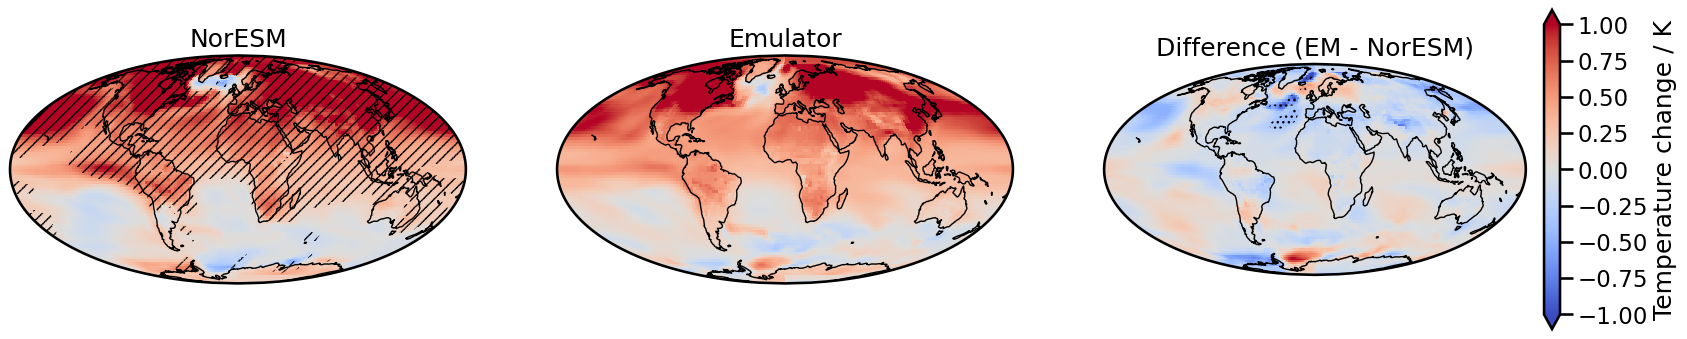

In [9]:
#plot test:

#un-normalize posterior:
posterior_mean = (standard_posterior_mean * train_output_df.std()) + train_output_df.mean()
train_std = tf.expand_dims(train_output_df.std(),axis=0)
posterior_std = np.sqrt(standard_posterior_var) * train_std

posterior_tas = np.reshape(posterior_mean, np.shape(test_output))#[years, 96, 144])
posterior_tas_std = np.reshape(posterior_std, np.shape(test_output))#[years, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=test_output.dims, coords=test_output.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=test_output.dims, coords=test_output.coords)

#get periods for comparison plot:
output_std = test_output.sel(year=slice(2050,2059)).std('year')
post_std = np.sqrt(np.power(posterior_tas_std_data.sel(year=slice(2050,2059)),2).mean('year'))

output_mean = test_output.sel(year=slice(2050,2059)).mean('year')
post_mean = posterior_tas_data.sel(year=slice(2050, 2059)).mean('year')

#ttest where difference between prediction and NorESM is significant:
from scipy.stats import ttest_ind_from_stats as ttest
z_em,p_em = ttest(output_mean, output_std, 10, post_mean, post_std, 10, equal_var=False, alternative='two-sided')

divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
diffnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
proj = ccrs.Mollweide()

t1_pgrid = np.load('C:/Users/made2928/OneDrive/Documents/MISU/NorESMem/ramip_t1_NorESMpgrid',allow_pickle=True)
p1mask = np.ma.masked_greater(t1_pgrid, 0.05)

with sns.plotting_context("talk"):
    ## Truth
    fig = plt.figure(figsize=(20, 6))
 
    plt.subplot(131, projection=proj)
    output_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.pcolor(test_output.lon, test_output.lat, p1mask[4,:,:], hatch='///', alpha=0., transform=ccrs.PlateCarree())
                      
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='NorESM')


    # Emulator
    plt.subplot(132, projection=proj)
    post_mean.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Emulator')

    # Difference
    difference = post_mean - output_mean
    plt.subplot(133, projection=proj)
    difference.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=diffnorm,
                    cbar_kwargs={"label":"Temperature change / K",'pad':0.04,'fraction':0.035})
    cs = plt.contourf(difference.lon, difference.lat, p_em, colors='none', levels=[0,0.05],
                    hatches=['...'], alpha=0., transform=ccrs.PlateCarree())


    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference (EM - NorESM)')


Text(0, 0.5, 'Global mean temperature change / K')

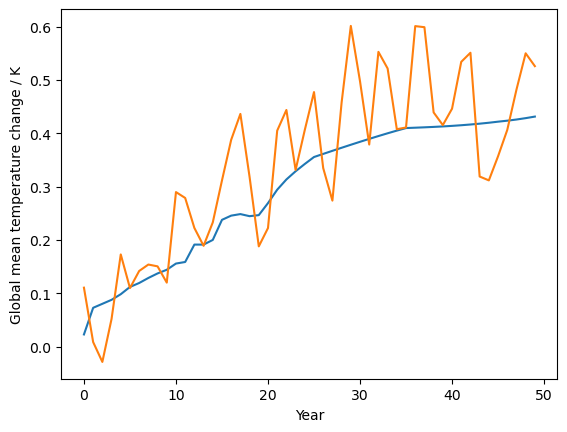

In [10]:
#plot global mean tas comparison:
plt.plot(lat_weighted_mean(posterior_tas_data))
plt.plot(lat_weighted_mean(test_output))
plt.xlabel('Year')
plt.ylabel('Global mean temperature change / K')

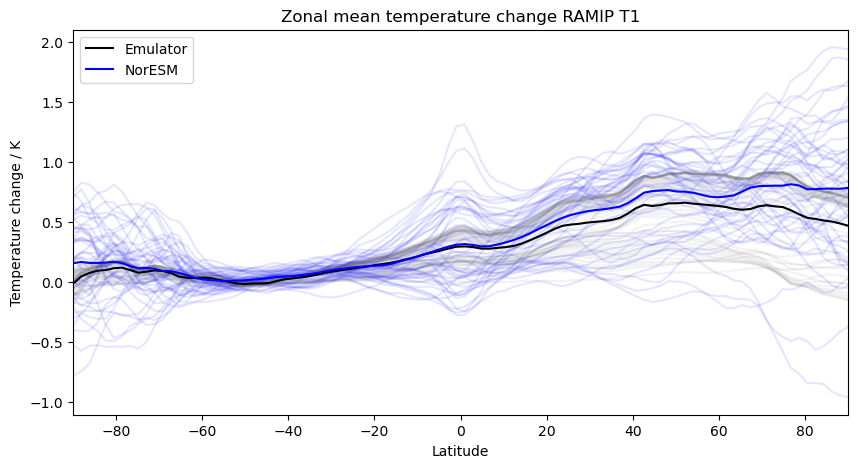

In [10]:
#zonal temperature change:
zonal_post = posterior_tas_data.mean('lon')
zonal_post_std = posterior_tas_std_data.mean('lon').mean('year')
zonal_truth = test_output.mean('lon')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for ii in range(50):
    plt.plot(zonal_post.lat, zonal_post[ii,:],color='grey', alpha=0.1)
    plt.plot(zonal_truth.lat, zonal_truth[ii,:], color='blue', alpha=0.1)
plt.plot(zonal_post.lat, zonal_post.mean('year'), color='black', label='Emulator')
plt.plot(zonal_truth.lat, zonal_truth.mean('year'), color='blue', label='NorESM')
plt.xlabel('Latitude')
plt.ylabel('Temperature change / K')
plt.legend()
plt.title('Zonal mean temperature change RAMIP T1')
plt.autoscale(enable=True, axis='x', tight=True)

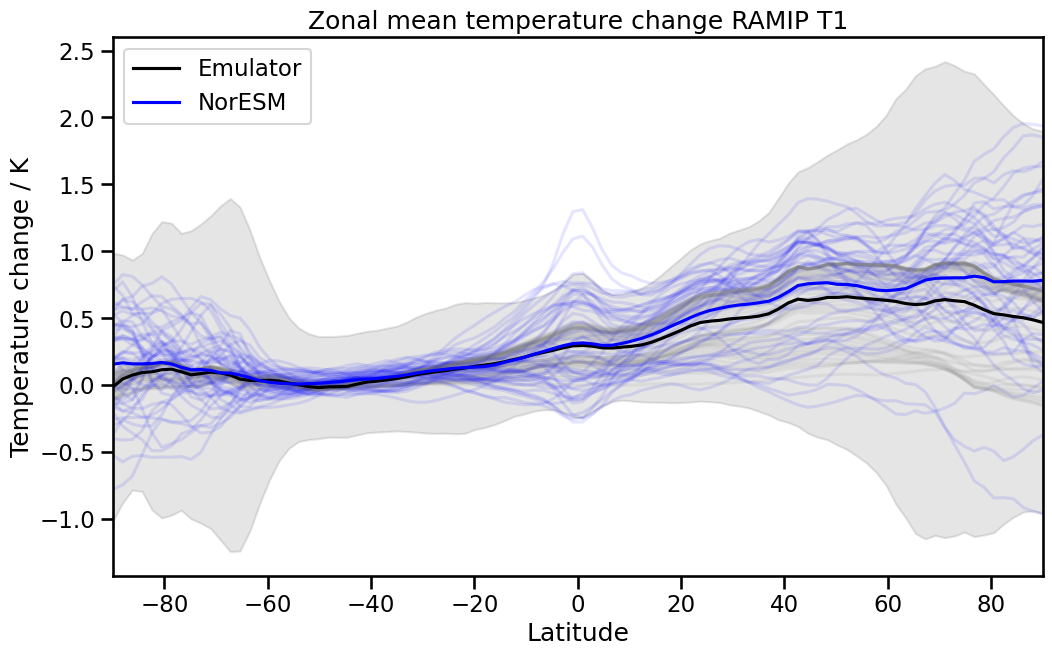

In [11]:
#zonal temperature change with emulator variance:

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    for ii in range(50):
        plt.plot(zonal_post.lat, zonal_post[ii,:],color='grey', alpha=0.1)
        plt.plot(zonal_truth.lat, zonal_truth[ii,:], color='blue', alpha=0.1)
    plt.plot(zonal_post.lat, zonal_post.mean('year'), color='black', label='Emulator')
    plt.fill_between(zonal_post.lat, zonal_post.mean('year')-zonal_post_std, zonal_post.mean('year')+zonal_post_std, color='black', alpha=0.1)
    plt.plot(zonal_truth.lat, zonal_truth.mean('year'), color='blue', label='NorESM')
    plt.xlabel('Latitude')
    plt.ylabel('Temperature change / K')
    plt.legend()
    plt.title('Zonal mean temperature change RAMIP T1')
    plt.autoscale(enable=True, axis='x', tight=True)

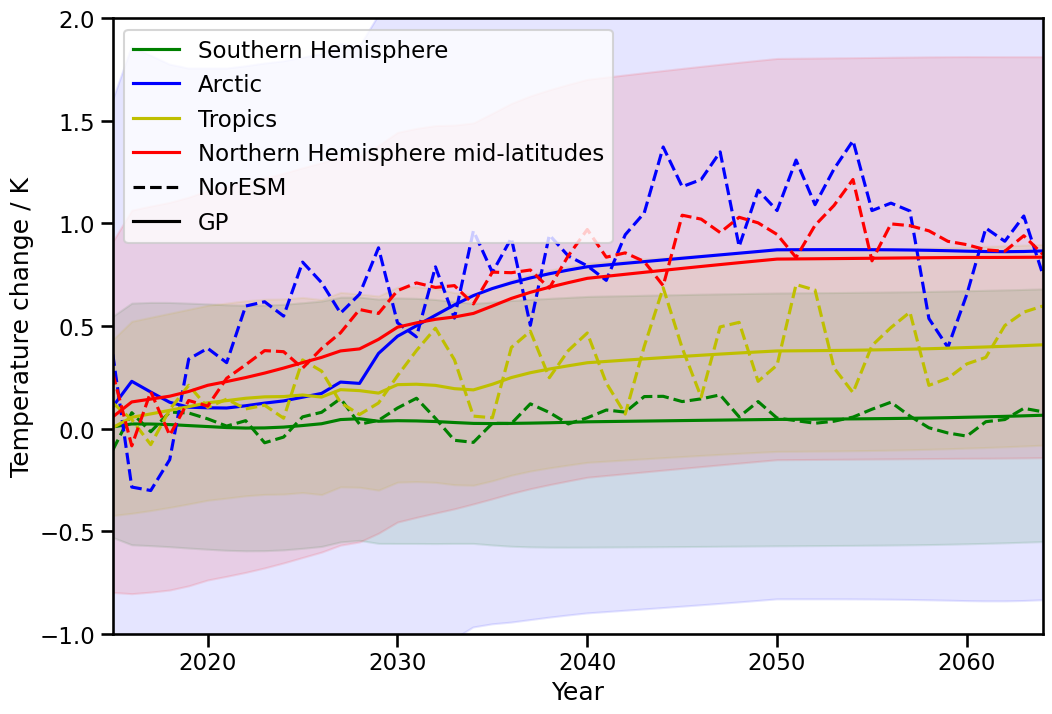

In [12]:
#trends in zonal means:
SH_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-90,-30)))
SH_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-90,-30)))
SH_truth = lat_weighted_mean(test_output.sel(lat=slice(-90,-30)))
Arctic_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(60,90)))
Arctic_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(60,90)))
Arctic_truth = lat_weighted_mean(test_output.sel(lat=slice(60,90)))
tropics_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-30,30)))
tropics_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-30,30)))
tropics_truth = lat_weighted_mean(test_output.sel(lat=slice(-30,30)))
NHml_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(30,60)))
NHml_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(30,60)))
NHml_truth = lat_weighted_mean(test_output.sel(lat=slice(30,60)))

test_var = xr.open_dataset(test_out)['diff_var']
SH_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-90,-30))))
Arctic_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(60,90))))
tropics_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-30,30))))
NHml_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(30,60))))


with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    SH_post.plot(label='Southern Hemisphere',color='g')
    plt.fill_between(SH_post.year, SH_post-SH_post_std, SH_post+SH_post_std, color='g', alpha=0.1)
    SH_truth.plot(color='g',linestyle='--')
    Arctic_post.plot(label='Arctic',color='b')
    plt.fill_between(Arctic_post.year, Arctic_post-Arctic_post_std, Arctic_post+Arctic_post_std, color='b', alpha=0.1)
    Arctic_truth.plot(color='b',linestyle='--')
    tropics_post.plot(label='Tropics',color='y')
    plt.fill_between(tropics_post.year, tropics_post-tropics_post_std, tropics_post+tropics_post_std, color='y', alpha=0.1)
    tropics_truth.plot(color='y',linestyle='--')
    NHml_post.plot(label='Northern Hemisphere mid-latitudes',color='r')
    plt.fill_between(NHml_post.year, NHml_post-NHml_post_std, NHml_post+NHml_post_std, color='r', alpha=0.1)
    NHml_truth.plot(color='r',linestyle='--')

    # create manual symbols for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    from matplotlib.lines import Line2D
    line1 = Line2D([0], [0], label='NorESM', color='k', linestyle='--')
    line2 = Line2D([0], [0], label='GP', color='k', linestyle='-')
    handles.extend([line1,line2])

    plt.xlabel('Year')
    plt.ylabel('Temperature change / K')
    plt.legend(loc='upper left',handles=handles)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(-1., 2.)